In [1]:

import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from src.environ import DIR
from src.algo.boost.lgbt import lgbm_plot , lgbm_weight
from typing import Any , Literal , Optional

dict_df : dict[str,Any] = {
    'train' : pd.read_csv(f'{DIR.data}/tree_data/df_train.csv' , index_col=[0,1]) , 
    'valid' : pd.read_csv(f'{DIR.data}/tree_data/df_valid.csv' , index_col=[0,1]) , 
    'test'  : pd.read_csv(f'{DIR.data}/tree_data/df_test.csv' , index_col=[0,1]) , 
}

# %%
"""
file_path = '/root/autodl-tmp/rnn_fac/data/risk_model.h5'
rm_file = h5py.File(file_path , mode='r+')
# pd.DataFrame(rm_file.get('20000106')[:])
file_path = '/root/autodl-tmp/rnn_fac/data/day_ylabels_data.h5'
y_file = h5py.File(file_path , mode='r+')
y , yTradeDate , ySecID = tuple([y_file.get(arr)[:] for arr in ['Y10' , 'TradeDate' , 'SecID']])

TradeDate = sorted(np.intersect1d(np.array(list(rm_file.keys() - ['colnames'])).astype(int) , yTradeDate))
dict_date = {
    'test':TradeDate[-50:],
    'valid':TradeDate[-50:],
    'train':TradeDate[-200:-50],
}
dict_df = {}
feature_names = np.concatenate((rm_file.get('colnames')[6:].astype(str),['y']))
for set_name in ['test' , 'valid' , 'train']:
    df_set = None
    for d in dict_date[set_name]:
        tmp = pd.DataFrame(rm_file.get(str(d))[:])
        pos = np.intersect1d(tmp.SecID , ySecID , return_indices= True)
        df = pd.DataFrame({'TradeDate' : str(d) , **tmp.iloc[pos[1],:] , 'y':y[pos[2],np.where(yTradeDate == d)].flatten()})
        df = df.set_index(['TradeDate','SecID']).loc[:,feature_names]
        df_set = pd.concat((df_set , df))
    dict_df[set_name] = df_set
"""


"\nfile_path = '/root/autodl-tmp/rnn_fac/data/risk_model.h5'\nrm_file = h5py.File(file_path , mode='r+')\n# pd.DataFrame(rm_file.get('20000106')[:])\nfile_path = '/root/autodl-tmp/rnn_fac/data/day_ylabels_data.h5'\ny_file = h5py.File(file_path , mode='r+')\ny , yTradeDate , ySecID = tuple([y_file.get(arr)[:] for arr in ['Y10' , 'TradeDate' , 'SecID']])\n\nTradeDate = sorted(np.intersect1d(np.array(list(rm_file.keys() - ['colnames'])).astype(int) , yTradeDate))\ndict_date = {\n    'test':TradeDate[-50:],\n    'valid':TradeDate[-50:],\n    'train':TradeDate[-200:-50],\n}\ndict_df = {}\nfeature_names = np.concatenate((rm_file.get('colnames')[6:].astype(str),['y']))\nfor set_name in ['test' , 'valid' , 'train']:\n    df_set = None\n    for d in dict_date[set_name]:\n        tmp = pd.DataFrame(rm_file.get(str(d))[:])\n        pos = np.intersect1d(tmp.SecID , ySecID , return_indices= True)\n        df = pd.DataFrame({'TradeDate' : str(d) , **tmp.iloc[pos[1],:] , 'y':y[pos[2],np.where(yTradeD

In [2]:
from typing import Any , Literal , Optional

class lgbm():
    var_date=['TradeDate','datetime'] 
    def __init__(self , 
                 train : Any = '../../data/tree_data/df_train.csv' , 
                 valid : Any = '../../data/tree_data/df_valid.csv' ,
                 test  : Any  = '../../data/tree_data/df_test.csv' , 
                 use_features = None , 
                 plot_path = '../../figures' ,
                 cuda = False , **kwargs):   
        if 'weight_param' in kwargs.keys():
            self.weight_param = kwargs['weight_param']
        else:
            self.weight_param = {'tau':0.75*np.log(0.5)/np.log(0.75) , 'decay':'exp' , 'rate':0.5}  
        self.train_param = {
            'objective': 'regression', 
            'verbosity': -1 , 
            'linear_tree': True, 
            'learning_rate': 0.3, 
            'lambda_l2': 1e-05, 
            'alpha': 1e-07, 
            'num_leaves': 31,
            'max_depth': 6, 
            # 'min_data_in_leaf' : 1, 
            'min_sum_hessian_in_leaf': 1, 
            'feature_fraction': 0.6, 
            'bagging_fraction': 0.75, 
            'force_col_wise': True, 
            'monotone_constraints': 1 , 
            'early_stopping' : 50 , 
            'zero_as_missing' : False ,
            'device_type': 'gpu' if cuda else 'cpu', # 'cuda' 'cpu'
            'seed': 42,
        }
        self.plot_path = plot_path
        self.train_param.update(kwargs)
        self.train = train
        self.valid = valid
        self.test  = test
        self.use_features = use_features

        #self.data_import(train , valid , test)
        #self.data_prepare(use_features)

    def calc_ic(self , pred , label , dropna = False):
        df = pd.DataFrame({'pred': pred, 'label': label})
        var_date = [v for v in self.var_date if v in df.index.names][0]
        ic = df.groupby(var_date).apply(lambda df: df['pred'].corr(df['label']))
        ric = df.groupby(var_date).apply(lambda df: df['pred'].corr(df['label'], method='spearman'))
        return (ic.dropna(), ric.dropna()) if dropna else (ic, ric)
        
    def data_import(self):
        if isinstance(self.train , str): self.train = pd.read_csv(self.train,index_col=[0,1])
        if isinstance(self.valid , str): self.valid = pd.read_csv(self.valid,index_col=[0,1])
        if isinstance(self.test , str):  self.test = pd.read_csv(self.test,index_col=[0,1])
        self.raw_dataset = {
            'train' : self.train.copy() ,
            'valid' : self.valid.copy() ,
            'test'  : self.test.copy()
        }
        assert len(self.raw_dataset['train'].columns) == len(self.raw_dataset['valid'].columns) == len(self.raw_dataset['test'].columns)

    def data_prepare(self , use_features = None , weight_param = None):
        self.assert_features(use_features)
        self.create_dataset(weight_param)       

    def assert_features(self , use_features):
        self.features = self.raw_dataset['train'].columns[:-1].values if use_features is None else use_features
        mono_constr = self.train_param['monotone_constraints']
        n_feat = len(self.features)
        if isinstance(mono_constr , list):
            if len(mono_constr) == 0: mono_constr = None
            elif len(mono_constr) != n_feat: mono_constr = (mono_constr*n_feat)[:n_feat]
        else:
            mono_constr = [mono_constr for _ in range(n_feat)]
        self.train_param['monotone_constraints'] = mono_constr

    def create_dataset(self , weight_param = None):
        weight_param = self.weight_param if weight_param is None else weight_param
        self.x_train = self.raw_dataset['train'].loc[:,self.features]
        self.x_valid = self.raw_dataset['valid'].loc[:,self.features] 
        self.y_train, self.y_valid = self.raw_dataset['train'].iloc[:,-1], self.raw_dataset['valid'].iloc[:,-1]
        assert self.y_train.values.ndim == 1 , "XGBoost doesn't support multi-label training"
        self.w_train = lgbm_weight.calculate_weight(self.y_train , weight_param)
        self.w_valid = lgbm_weight.calculate_weight(self.y_valid , weight_param)

        self.train_dataset = lgb.Dataset(self.x_train, self.y_train, weight=self.w_train)
        self.valid_dataset = lgb.Dataset(self.x_valid, self.y_valid, weight=self.w_valid , reference=self.train_dataset)

    def fit(self):
        self.evals_result = dict()
        self.model = lgb.train(
            self.train_param ,
            self.train_dataset, 
            valid_sets=[self.train_dataset, self.valid_dataset], 
            valid_names=['train', 'valid'] , 
            num_boost_round=1000 , 
            callbacks=[lgb.record_evaluation(self.evals_result)],
        )
        
    def predict(self , inputs : Any = None):
        if isinstance(inputs , (pd.DataFrame | pd.Series)):
            return pd.Series(np.array(self.model.predict(inputs)) , index=inputs.index)
        else:
            return self.model.predict(inputs)
    
    def test_result(self):
        x_test = self.raw_dataset['test'].loc[:,self.features]
        label  = self.raw_dataset['test'].iloc[:,-1]
        pred = self.predict(x_test)
        ic , ric = self.calc_ic(pred, label , dropna=True)
        plt.figure()
        ric.cumsum().plot(title='average Rank IC = %.4f'%ric.mean())
        plt.savefig('/'.join([self.plot_path,'test_prediction.png']),dpi=1200)
        return {'ic':ic , 'ric':ric}
    
    @property
    def plot(self): return lgbm_plot(self)

In [3]:
a = lgbm(**dict_df)


In [4]:
a.data_import()

In [5]:
a.data_prepare()

<Figure size 800x550 with 0 Axes>

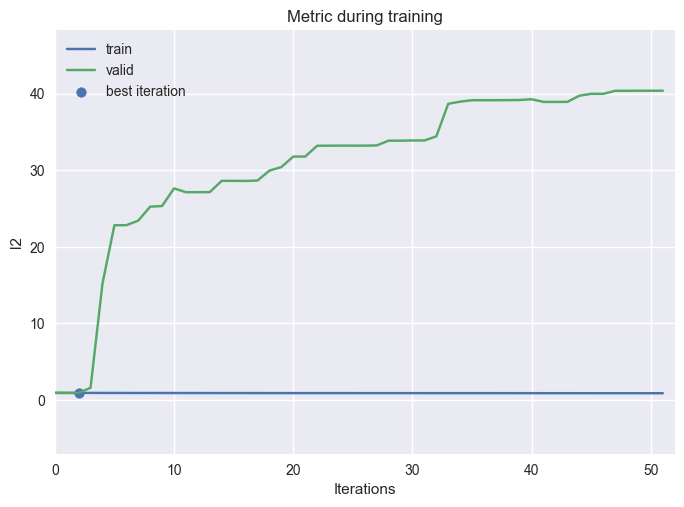

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

<Figure size 800x550 with 0 Axes>

In [6]:
a.fit()
a.plot.training()

In [ ]:
a.test_result()

In [ ]:
a.fit()

# %%
seqn = np.arange(dict_df['train'].shape[1])
use_features = dict_df['train'].iloc[:,[*seqn[-22:-1]]].columns.values
print(use_features)
a.data_prepare(use_features)
a.fit()


pred = a.test_result()

In [16]:
import numpy as np
import pandas as pd
from typing import Literal

y = pd.DataFrame({'SecID':np.arange(1000).repeat(2) , 'TradeDate' : np.tile(np.arange(2) , 1000) , 'y' : np.random.rand(2000)})
